### JPEG. Преобразование Фурье. Склейка изображений

#### Задача https://stepik.org/lesson/58410/step/5?unit=36069

In [1]:
import numpy as np
import json
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.fft import fftshift,fft2

1. Подготовьте одно изображение для экспериментов с гауссовской и лапласовской пирамидой.

2. (5 баллов) Постройте гауссовскую пирамиду изображения из не менее чем пяти слоев. Визуализируйте полученные изображения и амплитуды частот изображений пирамиды (код можно найти в видео про преобразование Фурье) и убедитесь, что на каждом слое диапазон частот сужается. Постройте пирамиду для трех различных значения сигмы гауссовского ядра. Для удобства экспериментирования определите отдельную функцию построения гауссовской пирамиды с параметрами img (изображение, по которому строится пирамида), sigma (параметр гауссовского ядра), n_layers (количество слоев пирамиды), возвращающую списки необходимых изображений

In [11]:
def Gaussia_pyramid(img:np.array,sigma:float,n_layers:int,printed=False):
    im=img.copy()
    img_yuv = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
    y, u, v = cv2.split(img_yuv)
    images,freqs=[im],[np.log(1 + abs(fftshift(fft2(y))))]
    for i in range(n_layers):
        # im=gaussian_filter(im,sigma=sigma)
        im=cv2.GaussianBlur(im,ksize=[0,0],sigmaX=sigma)
        img_yuv = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
        y, u, v = cv2.split(img_yuv)
        freq = np.log(1 + abs(fftshift(fft2(y))))
        images.append(im)
        freqs.append(freq)
        if printed:
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.imshow(im)
            plt.subplot(1,2,2)
            plt.imshow(freq)
            plt.show()
    return images,freqs

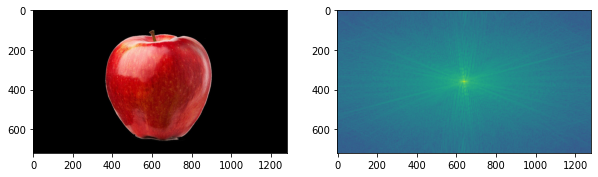

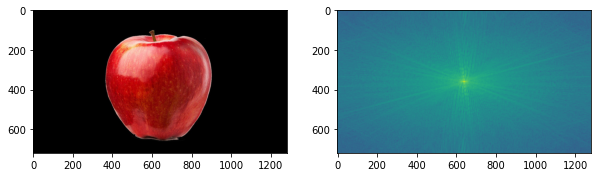

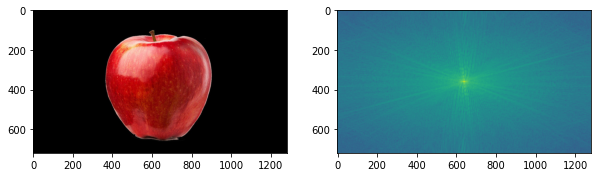

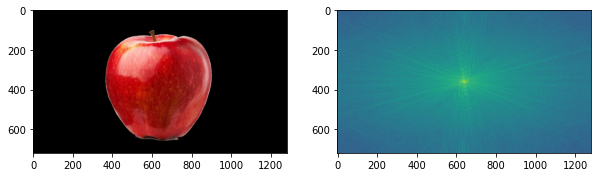

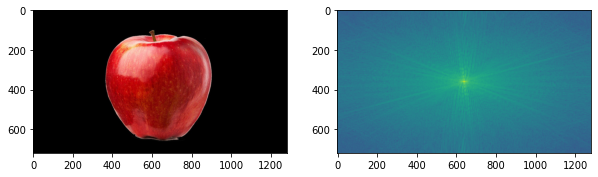

In [12]:
# img_path="/home/yuri/PycharmProjects/constr_engi/images_to_stick/apple.jpg"
img_path="images_to_stick/apple.jpg"
img=cv2.imread(img_path)[:,:,::-1]
sigma=0.3
n_layers=5
images,freq=Gaussia_pyramid(img,sigma,n_layers,printed=1)


3. (5 баллов) Проведите аналогичные эксперименты с лапласовской пирамидой. Функция для построения лапласовской пирамиды должна использовать функцию построения гауссовской пирамиды и иметь, как и функция гауссовской пирамиды, параметры img, sigma и n_layers.

In [13]:
def Laplass_pyramid(img:np.array,sigma:float,n_layers:int,printed=False):
    images,freqs=Gaussia_pyramid(img,sigma,n_layers,printed=0)
    imgs_laplass,freqs_laplass = [], []
    for i in range(len(images)-1):
        img_laplass=images[i]-images[i+1]
        freq_laplass=freqs[i]-freqs[i+1]
        imgs_laplass.append(img_laplass)
        freqs_laplass.append(freq_laplass)
        if printed:
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.imshow(img_laplass)
            plt.subplot(1,2,2)
            plt.imshow(freq_laplass)
            plt.show()
    imgs_laplass.append(images[-1])
    freqs_laplass.append(freqs[-1])
    return imgs_laplass,freqs_laplass

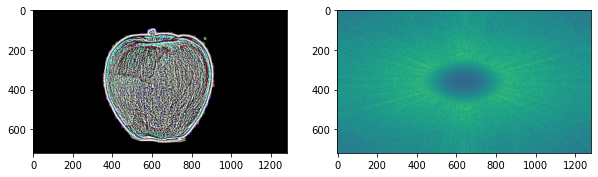

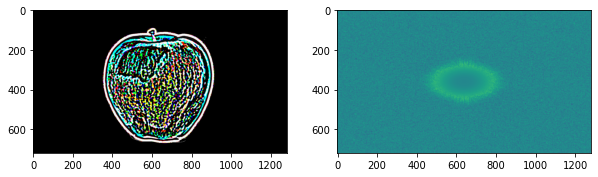

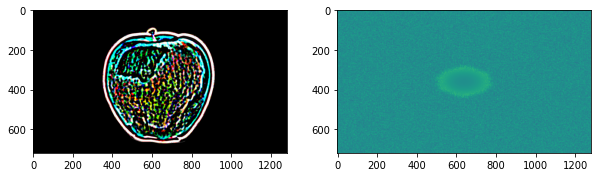

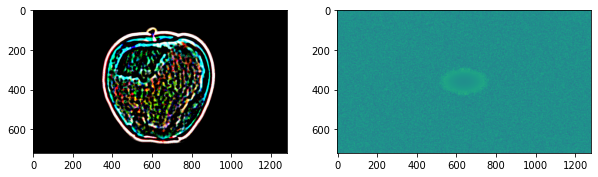

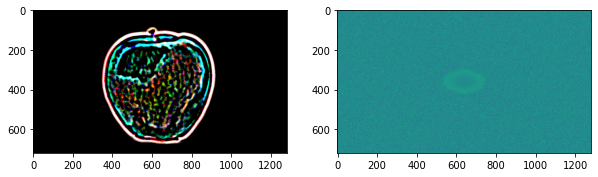

In [16]:
img_path="images_to_stick/apple.jpg"
img=cv2.imread(img_path)[:,:,::-1]
sigma=3
n_layers=5
imgs_laplass,freq_laplass=Laplass_pyramid(img,sigma,n_layers,printed=1)

4. (5 баллов) На основе функций построения гауссовской и лапласовской пирамиды напишите функцию склейки двух изображений на основе маски. Функция должна возвращать склееные изображения и промежуточные результаты — склееные изображения разных частот (т.е. лапласовскую пирамиду совмещенного изображения). Изображения для тестирования: a.png, b.png, mask.png. Изображение с маской не является бинарным (т.е. имеет промежуточные градации серого), его можно бинаризовать путём сравнения всех элементов с порогом 128:
mask = imread('mask.png')
mask = (mask > 128).astype('uint')

Посмотрите, как ведет себя склейка при изменении sigma (попробуйте три варианта значений при фиксированном количестве слоев в пирамидах) и при изменении количества слоев (попробуйте три варианта слоев при фиксированном sigma). Склейка должна выдавать качественный результат без видимых артефактов хотя бы с одним набором параметров.

In [20]:
def stick_images(img_A:np.array,img_B:np.array,mask:np.array,sigma:float,n_layers:int,save_to=None,printed=False):
    """
    Stick 3 images using mask
    :param img_A: 3 channel np array
    :param img_B: 3 channel np array
    :param mask: 3 channel np array with values 0 and 255
    :param sigma: sigma for mask must be higher than sigma for images
    :param save_to: directory to save images
    """
    LsA=Laplass_pyramid(img_A,sigma,n_layers,printed=False)[0]
    LsB=Laplass_pyramid(img_B,sigma,n_layers,printed=False)[0]
    GsM=Gaussia_pyramid(mask,sigma=6,n_layers=n_layers,printed=False)[0]
    GsM=[GM/255 for GM in GsM]
    LS=np.zeros(img_A.shape)
    level=0
    for LA,LB,GM in zip(LsA,LsB,GsM):
        L=GM*LA+(1-GM)*LB
        LS += L
        level+=1
        if save_to:
            name=f"sigma_{sigma}_layer_{level}.png"
            cv2.imwrite(os.path.join(save_to,name),LS)
    if printed:
        plt.imshow(LS)
        plt.show()
    return LS


5. (5 баллов) Подготовьте самостоятельно три набора изображений и масок для склейки и визуализируйте результаты функции. У вас должно получиться 3 качественных и интересных коллажа.

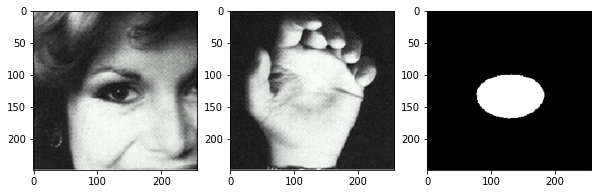

In [27]:
imgA_path="images_to_stick/face.png"
imgB_path="images_to_stick/hand.jpg"
mask_path="images_to_stick/mask.jpg"
save_to='images_to_stick'
img_A=cv2.imread(imgA_path)[:,:,::-1]
img_B=cv2.imread(imgB_path)[:,:,::-1]
mask = cv2.imread(mask_path)[:,:,::-1]
mask[mask < 128]=0
mask[mask >= 128]=255
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(img_A)
plt.subplot(1,3,2)
plt.imshow(img_B)
plt.subplot(1,3,3)
plt.imshow(mask)
plt.show()

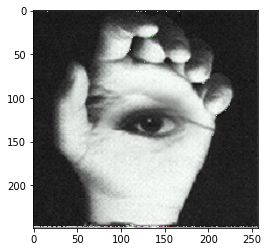

In [36]:
sigma=0.3
n_layers=5
LS=stick_images(img_A,img_B,mask,sigma,n_layers,save_to=save_to,printed=0)
result_path="images_to_stick/sigma_0.3_layer_6.png"
result=cv2.imread(result_path)
plt.imshow(result)
plt.show()

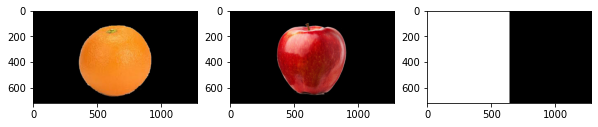

In [38]:
imgA_path="images_to_stick/orange.jpg"
imgB_path="images_to_stick/apple.jpg"
img_A=cv2.imread(imgA_path)
img_B=cv2.imread(imgB_path)
mask=np.zeros(img_A.shape)
mask[:,:img_A.shape[1]//2,:]=255
mask=mask.astype('uint8')
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(img_A[:,:,::-1])
plt.subplot(1,3,2)
plt.imshow(img_B[:,:,::-1])
plt.subplot(1,3,3)
plt.imshow(mask)
plt.show()


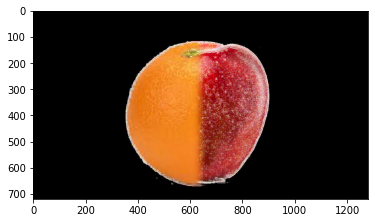

In [46]:
sigma=0.4
n_layers=5
LS=stick_images(img_A,img_B,mask,sigma,n_layers,save_to=save_to,printed=0)
result_path="images_to_stick/sigma_0.4_layer_6.png"
result=cv2.imread(result_path)[:,:,::-1]
plt.imshow(result)
plt.show()
